# Beyond Context Windows: Artifacts vs Context-Heavy Approach

This notebook demonstrates the core concepts from the blog post **"Beyond Context Windows: Why Artifacts Are the Secret Sauce to Scalable AI Agents"**.

## Overview

We'll compare two approaches for AI agent analytics:

1. **Context-Heavy Approach**: Agent receives all records as function parameters
2. **Artifact-Based Approach**: Agent receives only an artifact reference (file path)

**Metrics measured:**
- ⏱️ Execution time
- 💰 Token usage (cost)
- ✅ Quality of results (accuracy)

---


## Installation

First, let's install all required dependencies. Run this cell once before proceeding.


In [ ]:
# Uncomment and run this cell if you need to install dependencies
# !pip install pandas numpy matplotlib seaborn agno openai

print("✅ Installation cell ready")
print("💡 Uncomment the install command above if you need to install packages")



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip
✅ Installation cell ready
💡 Uncomment the appropriate install command above if you need to install packages


## Setup and Imports


In [ ]:
import os
import time
import json
import pandas as pd
import numpy as np
from typing import Dict, Any
from dataclasses import dataclass
import matplotlib.pyplot as plt
from agno.agent import Agent
from agno.models.openai import OpenAIChat

# Verify API key is set
os.environ["OPENAI_API_KEY"] = "<your_api_key_here>"

print("✅ All imports successful")


✅ All imports successful


## Load Your Salesforce Data

We'll load your existing `salesforce_test_data.csv` file for the experiments.


In [ ]:
# Load Salesforce data (limiting to 200 records for demonstration)
dataset = pd.read_csv("https://raw.githubusercontent.com/yess-ai/yess-blogs/refs/heads/main/context_is_not_a_storage_unit/salesforce_test_data.csv")[:200]

print(f"✅ Loaded dataset: {len(dataset)} records")
print(f"   Size: {dataset.memory_usage(deep=True).sum() / 1024:.2f} KB")
print(f"   Columns: {list(dataset.columns)}")
print(f"   Shape: {dataset.shape}")

# Save a copy for the artifact-based experiment
artifact_file = "salesforce_data_artifact.csv"
dataset.to_csv(artifact_file, index=False)
print(f"\n📁 Created artifact file: {artifact_file}")

print("\n📊 Sample records:")
print(dataset.head())


✅ Loaded dataset: 200 records
   Size: 245.41 KB
   Columns: ['First Name', 'Last Name', 'Email', 'Company', 'Title', 'Phone', 'Mobile', 'Street', 'City', 'State', 'Zip Code', 'Country', 'Industry', 'Lead Source', 'Lead Status', 'Annual Revenue', 'Employees', 'Website', 'Created Date', 'Last Modified Date']
   Shape: (200, 20)

📁 Created artifact file: salesforce_data_artifact.csv

📊 Sample records:
  First Name Last Name                                    Email  \
0    Dorothy   Ramirez  dorothy.ramirez@alliancecorporation.com   
1      Linda   Roberts            linda.roberts@momentuminc.com   
2   Margaret   Collins    margaret.collins@nexuscorporation.com   
3      Susan    Nelson       susan.nelson@summitenterprises.com   
4     Ronald  Phillips          ronald.phillips@genesiscorp.com   

                Company                     Title           Phone  \
0  Alliance Corporation    Senior Account Manager  (577) 543-9174   
1          Momentum Inc               VP of Sales  (783)

## Define Analytics Tools

We'll create two versions of the analytics tool:
1. **Context-heavy**: Receives all records as parameters
2. **Artifact-based**: Receives only a file path reference


In [84]:
from pydantic import BaseModel, Field


class LeadsAnalysis(BaseModel):
    """Complete Salesforce leads analysis results"""
    # Basic info
    total_records: int = Field(description="Total number of records analyzed")
    qualified_rate: float = Field(description="Percentage of qualified leads")

    # Max revenue info
    max_revenue_value: float = Field(description="Maximum annual revenue value")
    max_revenue_company: str = Field(description="Company with maximum revenue")
    max_revenue_state: str = Field(description="State of company with maximum revenue")

    # Revenue by state (top state)
    highest_revenue_state: str = Field(description="State with highest maximum revenue")
    highest_revenue_value: float = Field(description="Highest revenue value by state")

    # Qualified leads (top states)
    top_qualified_state: str = Field(description="State with most qualified leads")
    top_qualified_count: int = Field(description="Number of qualified leads in top state")
    total_qualified: int = Field(description="Total qualified leads across all states")

    # Industry with most employees
    largest_industry: str = Field(description="Industry with largest average employee count")
    largest_industry_avg_employees: float = Field(description="Average employees in largest industry")

    # Summary counts
    total_lead_statuses: int = Field(description="Number of different lead statuses")
    total_industries: int = Field(description="Number of different industries")
    total_lead_sources: int = Field(description="Number of different lead sources")


def perform_analysis(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Shared analysis logic answering key business questions.
    Returns a flattened structure compatible with structured outputs.
    """
    analysis = {
        "total_records": len(df),
        "qualified_rate": 0.0,
        "max_revenue_value": 0.0,
        "max_revenue_company": "Unknown",
        "max_revenue_state": "Unknown",
        "highest_revenue_state": "Unknown",
        "highest_revenue_value": 0.0,
        "top_qualified_state": "Unknown",
        "top_qualified_count": 0,
        "total_qualified": 0,
        "largest_industry": "Unknown",
        "largest_industry_avg_employees": 0.0,
        "total_lead_statuses": 0,
        "total_industries": 0,
        "total_lead_sources": 0,
    }

    # Clean Annual Revenue column
    if "Annual Revenue" in df.columns:
        df["Annual Revenue Clean"] = (
            df["Annual Revenue"]
            .str.replace('$', '', regex=False)
            .str.replace(',', '', regex=False)
            .astype(float)
        )

    # Q1: Maximum annual revenue
    if "Annual Revenue Clean" in df.columns and len(df) > 0:
        max_revenue_idx = df["Annual Revenue Clean"].idxmax()
        max_revenue_row = df.loc[max_revenue_idx]
        analysis["max_revenue_value"] = float(max_revenue_row["Annual Revenue Clean"])
        analysis["max_revenue_company"] = str(max_revenue_row.get("Company", "Unknown"))
        analysis["max_revenue_state"] = str(max_revenue_row.get("State", "Unknown"))

    # Q2: Maximum revenue by state
    if "Annual Revenue Clean" in df.columns and "State" in df.columns:
        max_by_state = df.groupby("State")["Annual Revenue Clean"].max().sort_values(ascending=False)
        if len(max_by_state) > 0:
            analysis["highest_revenue_state"] = str(max_by_state.index[0])
            analysis["highest_revenue_value"] = float(max_by_state.iloc[0])

    # Q3: Qualified leads by state
    if "Lead Status" in df.columns and "State" in df.columns:
        qualified_df = df[df["Lead Status"] == "Qualified"]
        analysis["total_qualified"] = int(len(qualified_df))

        if len(qualified_df) > 0:
            qualified_by_state = qualified_df.groupby("State").size().sort_values(ascending=False)
            if len(qualified_by_state) > 0:
                analysis["top_qualified_state"] = str(qualified_by_state.index[0])
                analysis["top_qualified_count"] = int(qualified_by_state.iloc[0])

    # Q4: Average employees by industry
    if "Employees" in df.columns and "Industry" in df.columns:
        avg_employees = df.groupby("Industry")["Employees"].mean().sort_values(ascending=False)
        if len(avg_employees) > 0:
            analysis["largest_industry"] = str(avg_employees.index[0])
            analysis["largest_industry_avg_employees"] = float(avg_employees.iloc[0])

    # Summary statistics
    if "Lead Status" in df.columns:
        analysis["total_lead_statuses"] = int(df["Lead Status"].nunique())
        analysis["qualified_rate"] = float(
            (df["Lead Status"] == "Qualified").sum() / len(df) * 100
        )

    if "Industry" in df.columns:
        analysis["total_industries"] = int(df["Industry"].nunique())

    if "Lead Source" in df.columns:
        analysis["total_lead_sources"] = int(df["Lead Source"].nunique())

    return analysis


def analyze_leads_from_records(records: str) -> str:
    """
    ⚠️ CONTEXT-HEAVY APPROACH
    Analyze Salesforce leads by passing ALL records as function parameters.

    This consumes massive tokens as dataset size grows.

    Args:
        records: JSON string containing list of lead dictionaries

    Returns:
        JSON string with comprehensive analytics
    """
    # Parse and validate input
    if isinstance(records, str):
        try:
            records_list = json.loads(records)
        except json.JSONDecodeError as e:
            return json.dumps({"error": f"Invalid JSON format: {str(e)}"})
    elif isinstance(records, list):
        records_list = records
    else:
        return json.dumps({"error": f"Expected JSON string or list, got {type(records)}"})

    if not isinstance(records_list, list) or len(records_list) == 0:
        return json.dumps({"error": "Records must be a non-empty list"})

    # Create DataFrame and perform analysis
    try:
        df = pd.DataFrame(records_list)
        analysis = perform_analysis(df)
        return json.dumps(analysis, indent=2)
    except Exception as e:
        return json.dumps({"error": f"Analysis failed: {str(e)}"})


def analyze_leads_from_artifact(artifact_path: str) -> str:
    """
    ✅ ARTIFACT-BASED APPROACH
    Analyze Salesforce leads by passing only a file path reference.

    This keeps token usage minimal and scales to millions of records.

    Args:
        artifact_path: Path to CSV file containing lead records

    Returns:
        JSON string with comprehensive analytics
    """
    try:
        df = pd.read_csv(artifact_path)
        analysis = perform_analysis(df)
        return json.dumps(analysis, indent=2)
    except Exception as e:
        return json.dumps({"error": f"Analysis failed: {str(e)}"})


print("✅ Analytics tools and Pydantic models defined")
print("\n📋 Two approaches:")
print("   1. Context-Heavy: Pass ALL records as JSON → High token usage")
print("   2. Artifact-Based: Pass only file path → Minimal tokens")
print("\n🔍 Both answer the same business questions:")
print("   • Maximum annual revenue")
print("   • Revenue by state")
print("   • Qualified leads distribution")
print("   • Average employees by industry")
print("\n✨ Using structured outputs:")
print("   • LeadsAnalysis Pydantic model ensures type-safe responses")
print("   • Agent configured with output_model=LeadsAnalysis")
print("   • Enables reliable comparison without JSON parsing")


✅ Analytics tools and Pydantic models defined

📋 Two approaches:
   1. Context-Heavy: Pass ALL records as JSON → High token usage
   2. Artifact-Based: Pass only file path → Minimal tokens

🔍 Both answer the same business questions:
   • Maximum annual revenue
   • Revenue by state
   • Qualified leads distribution
   • Average employees by industry

✨ Using structured outputs:
   • LeadsAnalysis Pydantic model ensures type-safe responses
   • Agent configured with output_model=LeadsAnalysis
   • Enables reliable comparison without JSON parsing


## Metrics Calculation Utilities

Helper functions to extract token usage and calculate costs.


In [85]:
def calculate_cost_from_tokens(input_tokens: int, output_tokens: int, model: str) -> float:
    """Calculate cost based on OpenAI pricing."""
    pricing = {
        "gpt-5-mini": (0.250, 2.000),  # (input_cost_per_1M, output_cost_per_1M)
        "gpt-5-nano": (0.050, 0.400)
    }

    rates = pricing.get(model.lower(), pricing["gpt-5-mini"])
    input_cost = (input_tokens / 1_000_000) * rates[0]
    output_cost = (output_tokens / 1_000_000) * rates[1]

    return input_cost + output_cost


def extract_metrics_from_response(response) -> Dict[str, Any]:
    """Extract token usage and timing metrics from Agno RunOutput."""
    metrics = {
        "input_tokens": 0,
        "output_tokens": 0,
        "total_tokens": 0,
        "time_to_first_token": 0.0,
        "response_time": 0.0,
        "cost": 0.0,
        "model": "unknown"
    }

    if hasattr(response, 'metrics') and response.metrics:
        metrics["input_tokens"] = getattr(response.metrics, 'input_tokens', 0)
        metrics["output_tokens"] = getattr(response.metrics, 'output_tokens', 0)
        metrics["total_tokens"] = getattr(response.metrics, 'total_tokens', 0)
        metrics["time_to_first_token"] = getattr(response.metrics, 'time_to_first_token', 0.0)
        metrics["response_time"] = getattr(response.metrics, 'response_time', 0.0)

    if hasattr(response, 'model') and response.model:
        metrics["model"] = response.model

    if metrics["input_tokens"] > 0 or metrics["output_tokens"] > 0:
        metrics["cost"] = calculate_cost_from_tokens(
            metrics["input_tokens"],
            metrics["output_tokens"],
            metrics["model"]
        )

    return metrics


print("✅ Metrics extraction utilities ready")
print("📊 Using Agno's real token counts + OpenAI pricing")


✅ Metrics extraction utilities ready
📊 Using Agno's real token counts + OpenAI pricing


## Metrics Collection

Define a dataclass to track our metrics across experiments.


In [86]:
@dataclass
class ExperimentMetrics:
    """Metrics for each experiment run"""
    approach: str  # "context-heavy" or "artifact-based"
    dataset_size: int
    execution_time: float  # seconds
    input_tokens: int
    output_tokens: int
    total_tokens: int
    estimated_cost: float  # dollars
    result: Dict[str, Any]
    error: str = None

    def __repr__(self):
        return (
            f"ExperimentMetrics(\n"
            f"  approach={self.approach},\n"
            f"  dataset_size={self.dataset_size:,},\n"
            f"  execution_time={self.execution_time:.2f}s,\n"
            f"  total_tokens={self.total_tokens:,},\n"
            f"  estimated_cost=${self.estimated_cost:.4f}\n"
            f")"
        )

print("✅ Metrics dataclass defined")


✅ Metrics dataclass defined


In [87]:
def get_agent(agent_name, tools):
    return Agent(
        name=agent_name,
        model=OpenAIChat(id="gpt-5-mini"),
        tools=tools,
        instructions=(
            "You are a Salesforce analytics expert. "
            "Use the analyze_leads tool to analyze the provided Salesforce leads data. "
            "Return a structured analysis with all the required fields."
        ),
        output_schema=LeadsAnalysis,
        markdown=True,
    )

---

## Experiment 1: Context-Heavy Approach

In this experiment, we pass **all records** as parameters to the agent's tool.

⚠️ **Problem**: As dataset size grows, this becomes:
- Expensive (massive token usage)
- Slow (large context processing)
- Error-prone (context window limits)


In [88]:
async def run_context_heavy_experiment(df: pd.DataFrame) -> ExperimentMetrics:
    """Run context-heavy experiment where all records are passed as parameters."""
    records = df.to_dict(orient="records")
    records_json = json.dumps(records)
    start_time = time.time()

    agent = get_agent("Context-Heavy Analytics Agent", [analyze_leads_from_records])

    try:
        response = agent.run(
            f"Analyze these {len(records)} Salesforce leads: {records_json}"
        )

        execution_time = time.time() - start_time
        metrics = extract_metrics_from_response(response)

        # Extract structured output (Pydantic model)
        analysis_result = None
        if hasattr(response, 'content') and response.content:
            # Convert Pydantic model to dict for comparison
            if isinstance(response.content, LeadsAnalysis):
                analysis_result = response.content.model_dump()
            else:
                analysis_result = response.content

        if not analysis_result:
            analysis_result = {"error": "No structured output received"}

        return ExperimentMetrics(
            approach="context-heavy",
            dataset_size=len(records),
            execution_time=execution_time,
            input_tokens=metrics["input_tokens"],
            output_tokens=metrics["output_tokens"],
            total_tokens=metrics["total_tokens"],
            estimated_cost=metrics["cost"],
            result={"analysis": analysis_result, "agent_response": response.content or ""}
        )

    except Exception as e:
        return ExperimentMetrics(
            approach="context-heavy",
            dataset_size=len(records),
            execution_time=time.time() - start_time,
            input_tokens=0,
            output_tokens=0,
            total_tokens=0,
            estimated_cost=0,
            result={"error": str(e)},
            error=str(e)
        )


print("✅ Context-heavy experiment function defined")


✅ Context-heavy experiment function defined


In [89]:
# Run context-heavy experiment
print("🔬 Running Context-Heavy Experiment...\n")
print(f"📊 Processing {len(dataset)} records through agent context...")

context_heavy_result = await run_context_heavy_experiment(dataset)
print("\n" + "="*70)
print("CONTEXT-HEAVY RESULTS:")
print("="*70)
print(context_heavy_result)
print("="*70)


🔬 Running Context-Heavy Experiment...

📊 Processing 200 records through agent context...

CONTEXT-HEAVY RESULTS:
ExperimentMetrics(
  approach=context-heavy,
  dataset_size=200,
  execution_time=294.69s,
  total_tokens=164,419,
  estimated_cost=$0.0836
)


---

## Experiment 2: Artifact-Based Approach

In this experiment, we pass **only a file reference** to the agent's tool.

✅ **Benefits**: Minimal token usage, scalable to millions of records, same accuracy.


In [90]:
async def run_artifact_based_experiment(csv_path: str, dataset_size: int) -> ExperimentMetrics:
    """Run artifact-based experiment where only a file reference is passed."""
    start_time = time.time()

    agent = get_agent("Artifact-Based Analytics Agent", [analyze_leads_from_artifact])

    try:
        response = agent.run(
            f"Analyze the Salesforce leads in this artifact: {csv_path}"
        )

        execution_time = time.time() - start_time
        metrics = extract_metrics_from_response(response)

        # Extract structured output (Pydantic model)
        analysis_result = None
        if hasattr(response, 'content') and response.content:
            # Convert Pydantic model to dict for comparison
            if isinstance(response.content, LeadsAnalysis):
                analysis_result = response.content.model_dump()
            else:
                analysis_result = response.content

        if not analysis_result:
            analysis_result = {"error": "No structured output received"}

        return ExperimentMetrics(
            approach="artifact-based",
            dataset_size=dataset_size,
            execution_time=execution_time,
            input_tokens=metrics["input_tokens"],
            output_tokens=metrics["output_tokens"],
            total_tokens=metrics["total_tokens"],
            estimated_cost=metrics["cost"],
            result={"analysis": analysis_result, "agent_response": response.content or ""}
        )

    except Exception as e:
        return ExperimentMetrics(
            approach="artifact-based",
            dataset_size=dataset_size,
            execution_time=time.time() - start_time,
            input_tokens=0,
            output_tokens=0,
            total_tokens=0,
            estimated_cost=0,
            result={"error": str(e)},
            error=str(e)
        )


print("✅ Artifact-based experiment function defined")


✅ Artifact-based experiment function defined


In [91]:
# Run artifact-based experiment
print("🔬 Running Artifact-Based Experiment...\n")
print(f"📊 Processing {len(dataset)} records via artifact reference...")

artifact_based_result = await run_artifact_based_experiment(artifact_file, len(dataset))
print("\n" + "="*70)
print("ARTIFACT-BASED RESULTS:")
print("="*70)
print(artifact_based_result)
print("="*70)


🔬 Running Artifact-Based Experiment...

📊 Processing 200 records via artifact reference...

ARTIFACT-BASED RESULTS:
ExperimentMetrics(
  approach=artifact-based,
  dataset_size=200,
  execution_time=6.37s,
  total_tokens=1,578,
  estimated_cost=$0.0007
)


---

## Results Comparison

Let's compare the metrics from both approaches.


In [92]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        "Approach": "Context-Heavy",
        "Dataset Size": context_heavy_result.dataset_size,
        "Execution Time (s)": context_heavy_result.execution_time,
        "Total Tokens": context_heavy_result.total_tokens,
        "Cost ($)": context_heavy_result.estimated_cost,
        "Input Tokens": context_heavy_result.input_tokens,
        "Output Tokens": context_heavy_result.output_tokens
    },
    {
        "Approach": "Artifact-Based",
        "Dataset Size": artifact_based_result.dataset_size,
        "Execution Time (s)": artifact_based_result.execution_time,
        "Total Tokens": artifact_based_result.total_tokens,
        "Cost ($)": artifact_based_result.estimated_cost,
        "Input Tokens": artifact_based_result.input_tokens,
        "Output Tokens": artifact_based_result.output_tokens
    }
])

print("\n" + "="*80)
print("📊 RESULTS COMPARISON")
print("="*80)
print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*80)



📊 RESULTS COMPARISON

      Approach  Dataset Size  Execution Time (s)  Total Tokens  Cost ($)  Input Tokens  Output Tokens
 Context-Heavy           200          294.687739        164419  0.083644        140111          24308
Artifact-Based           200            6.370850          1578  0.000673          1419            159



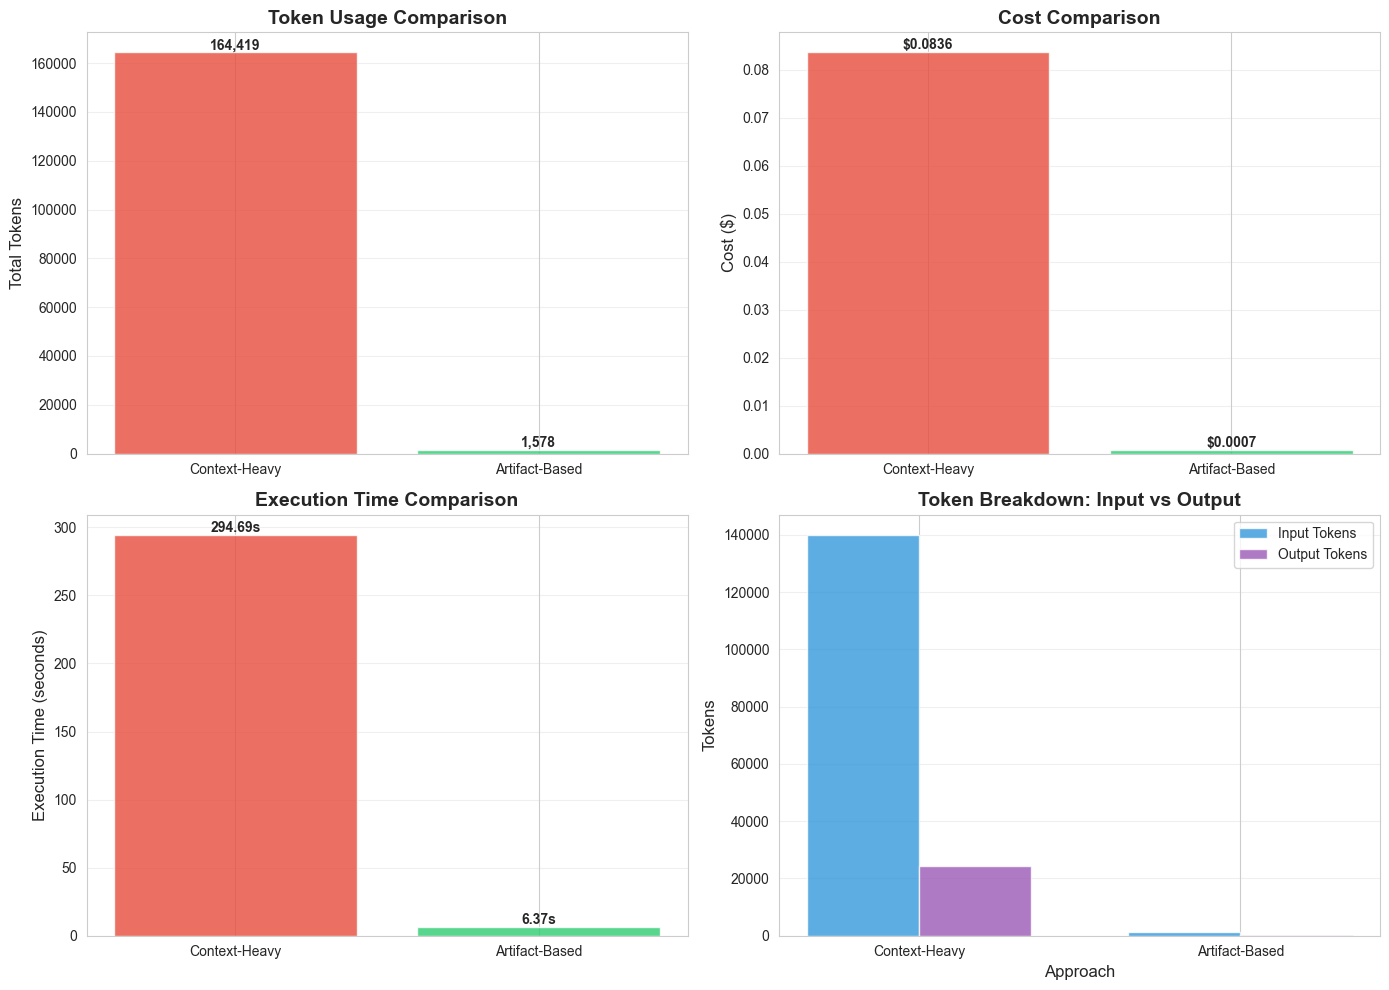

In [93]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
approaches = comparison_df["Approach"]
x_pos = np.arange(len(approaches))
colors = ['#e74c3c', '#2ecc71']  # Red for context-heavy, green for artifact-based

# Token Usage
ax1 = axes[0, 0]
bars1 = ax1.bar(x_pos, comparison_df["Total Tokens"], color=colors, alpha=0.8)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(approaches)
ax1.set_ylabel("Total Tokens", fontsize=12)
ax1.set_title("Token Usage Comparison", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df["Total Tokens"]):
    ax1.text(i, v, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Cost
ax2 = axes[0, 1]
bars2 = ax2.bar(x_pos, comparison_df["Cost ($)"], color=colors, alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(approaches)
ax2.set_ylabel("Cost ($)", fontsize=12)
ax2.set_title("Cost Comparison", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df["Cost ($)"]):
    ax2.text(i, v, f'${v:.4f}', ha='center', va='bottom', fontweight='bold')

# Execution Time
ax3 = axes[1, 0]
bars3 = ax3.bar(x_pos, comparison_df["Execution Time (s)"], color=colors, alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(approaches)
ax3.set_ylabel("Execution Time (seconds)", fontsize=12)
ax3.set_title("Execution Time Comparison", fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df["Execution Time (s)"]):
    ax3.text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontweight='bold')

# Token Breakdown
ax4 = axes[1, 1]
width = 0.35
x = np.arange(len(comparison_df))
ax4.bar(x - width/2, comparison_df["Input Tokens"], width,
        label='Input Tokens', alpha=0.8, color='#3498db')
ax4.bar(x + width/2, comparison_df["Output Tokens"], width,
        label='Output Tokens', alpha=0.8, color='#9b59b6')
ax4.set_xlabel("Approach", fontsize=12)
ax4.set_ylabel("Tokens", fontsize=12)
ax4.set_title("Token Breakdown: Input vs Output", fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(approaches)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Efficiency Metrics

Let's calculate the improvement percentages.



📈 EFFICIENCY IMPROVEMENTS (Artifact-Based vs Context-Heavy)

📊 Dataset: 200 records

🔹 Token Reduction: 99.0%
🔹 Cost Reduction: 99.2%
🔹 Time Improvement: 97.8%



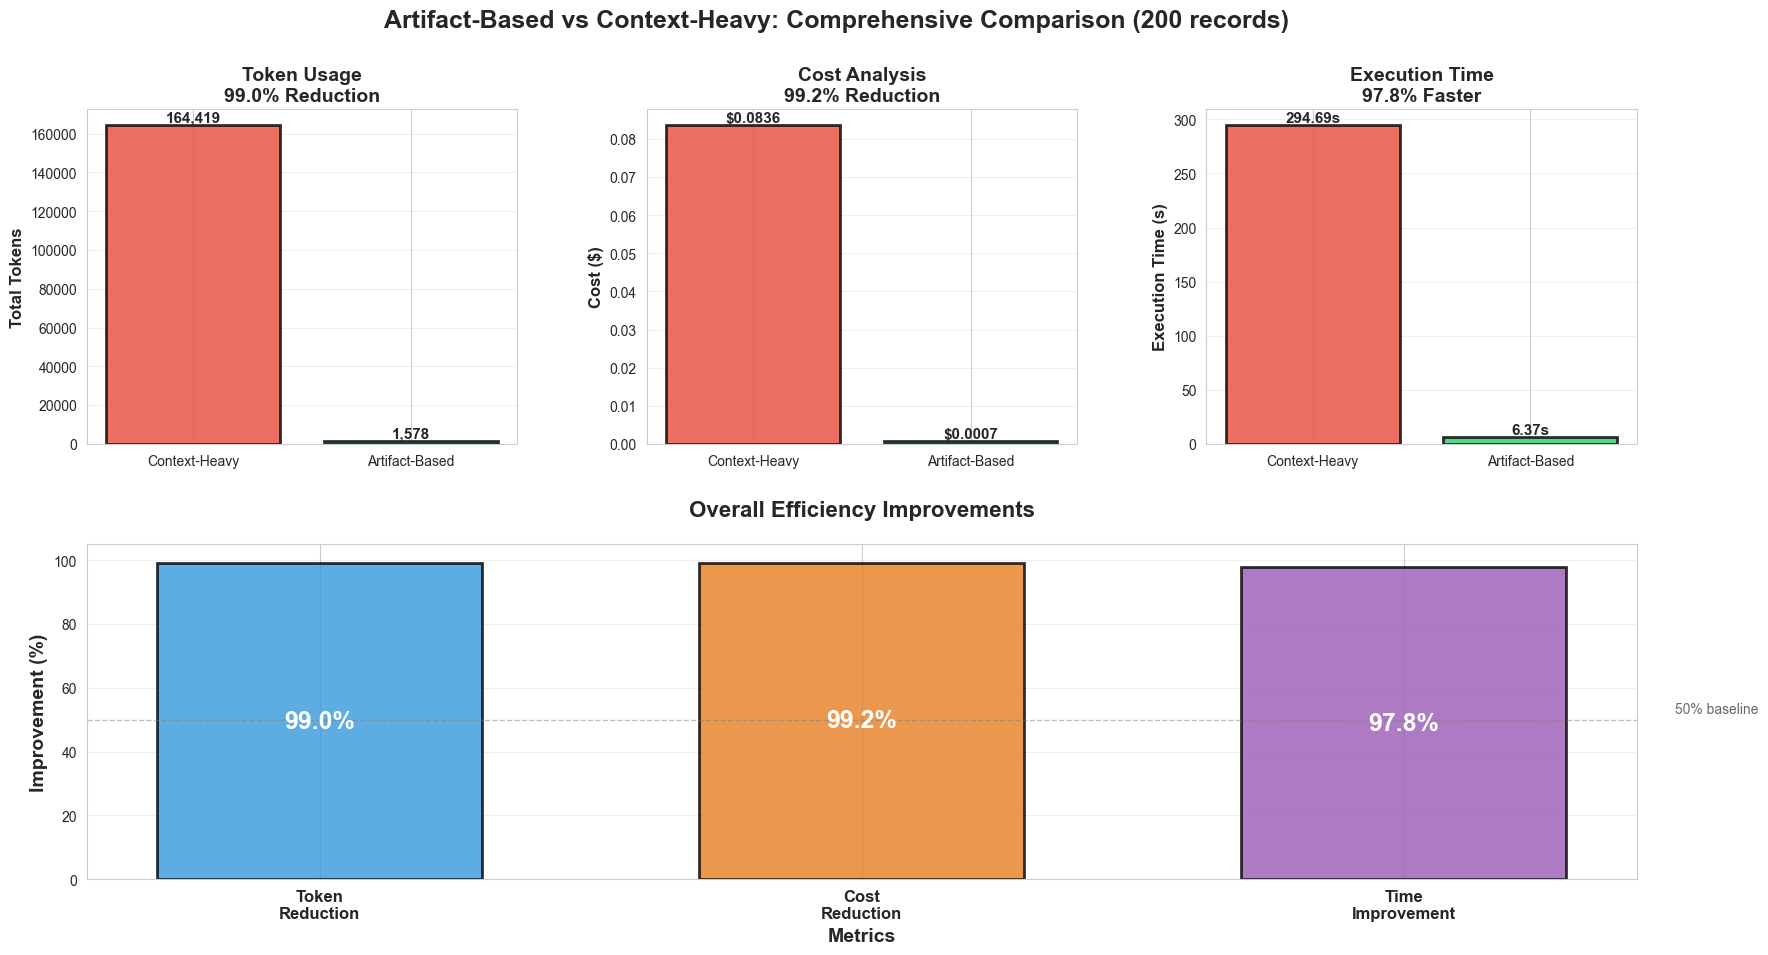


📊 DETAILED BREAKDOWN

🔹 Tokens:
   Context-Heavy:  164,419
   Artifact-Based: 1,578
   Savings:        162,841

🔹 Cost:
   Context-Heavy:  $0.0836
   Artifact-Based: $0.0007
   Savings:        $0.0830

🔹 Time:
   Context-Heavy:  294.69s
   Artifact-Based: 6.37s
   Savings:        288.32s



In [ ]:
def calculate_improvement(baseline: float, improved: float) -> float:
    """Calculate percentage improvement from baseline."""
    if baseline == 0:
        return 0
    return ((baseline - improved) / baseline) * 100


# Calculate improvements
token_improvement = calculate_improvement(
    context_heavy_result.total_tokens,
    artifact_based_result.total_tokens
)
cost_improvement = calculate_improvement(
    context_heavy_result.estimated_cost,
    artifact_based_result.estimated_cost
)
time_improvement = calculate_improvement(
    context_heavy_result.execution_time,
    artifact_based_result.execution_time
)

print("\n" + "="*80)
print("📈 EFFICIENCY IMPROVEMENTS (Artifact-Based vs Context-Heavy)")
print("="*80)
print(f"\n📊 Dataset: {context_heavy_result.dataset_size:,} records\n")
print(f"🔹 Token Reduction: {token_improvement:.1f}%")
print(f"🔹 Cost Reduction: {cost_improvement:.1f}%")
print(f"🔹 Time Improvement: {time_improvement:.1f}%")
print("\n" + "="*80)

# Create efficiency visualization
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

context_color = '#e74c3c'
artifact_color = '#2ecc71'
approaches = ['Context-Heavy', 'Artifact-Based']

# Token Comparison
ax1 = fig.add_subplot(gs[0, 0])
token_values = [context_heavy_result.total_tokens, artifact_based_result.total_tokens]
bars1 = ax1.bar(approaches, token_values, color=[context_color, artifact_color],
                alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('Total Tokens', fontsize=12, fontweight='bold')
ax1.set_title(f'Token Usage\n{token_improvement:.1f}% Reduction',
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars1, token_values):
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Cost Comparison
ax2 = fig.add_subplot(gs[0, 1])
cost_values = [context_heavy_result.estimated_cost, artifact_based_result.estimated_cost]
bars2 = ax2.bar(approaches, cost_values, color=[context_color, artifact_color],
                alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('Cost ($)', fontsize=12, fontweight='bold')
ax2.set_title(f'Cost Analysis\n{cost_improvement:.1f}% Reduction',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars2, cost_values):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'${val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Time Comparison
ax3 = fig.add_subplot(gs[0, 2])
time_values = [context_heavy_result.execution_time, artifact_based_result.execution_time]
bars3 = ax3.bar(approaches, time_values, color=[context_color, artifact_color],
                alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_ylabel('Execution Time (s)', fontsize=12, fontweight='bold')
ax3.set_title(f'Execution Time\n{time_improvement:.1f}% Faster',
              fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars3, time_values):
    ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
             f'{val:.2f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Improvement Percentages
ax4 = fig.add_subplot(gs[1, :])
metrics = ['Token\nReduction', 'Cost\nReduction', 'Time\nImprovement']
improvements = [token_improvement, cost_improvement, time_improvement]
colors_imp = ['#3498db', '#e67e22', '#9b59b6']

x_pos = range(len(metrics))
bars4 = ax4.bar(x_pos, improvements, color=colors_imp, alpha=0.8,
                edgecolor='black', linewidth=2, width=0.6)

for bar, val in zip(bars4, improvements):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
             f'{val:.1f}%', ha='center', va='center',
             fontsize=18, fontweight='bold', color='white')

ax4.set_ylabel('Improvement (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Metrics', fontsize=14, fontweight='bold')
ax4.set_title(':dart: Overall Efficiency Improvements', fontsize=16, fontweight='bold', pad=20)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics, fontsize=12, fontweight='bold')
ax4.set_ylim(0, 105)
ax4.axhline(y=50, color='gray', linestyle='--', alpha=0.5, linewidth=1)
ax4.text(len(metrics)-0.5, 52, '50% baseline', fontsize=10, alpha=0.7)
ax4.grid(True, alpha=0.3, axis='y')

fig.suptitle(
    f'Artifact-Based vs Context-Heavy: Comprehensive Comparison '
    f'({context_heavy_result.dataset_size:,} records)',
    fontsize=18, fontweight='bold', y=0.98
)

plt.show()

# Detailed breakdown
print("\n" + "="*80)
print("📊 DETAILED BREAKDOWN")
print("="*80)

print(f"\n🔹 Tokens:")
print(f"   Context-Heavy:  {context_heavy_result.total_tokens:,}")
print(f"   Artifact-Based: {artifact_based_result.total_tokens:,}")
print(f"   Savings:        {context_heavy_result.total_tokens - artifact_based_result.total_tokens:,}")

print(f"\n🔹 Cost:")
print(f"   Context-Heavy:  ${context_heavy_result.estimated_cost:.4f}")
print(f"   Artifact-Based: ${artifact_based_result.estimated_cost:.4f}")
print(f"   Savings:        ${context_heavy_result.estimated_cost - artifact_based_result.estimated_cost:.4f}")

print(f"\n🔹 Time:")
print(f"   Context-Heavy:  {context_heavy_result.execution_time:.2f}s")
print(f"   Artifact-Based: {artifact_based_result.execution_time:.2f}s")
print(f"   Savings:        {context_heavy_result.execution_time - artifact_based_result.execution_time:.2f}s")

print("\n" + "="*80)


## Quality Assessment

Let's verify that both approaches produce correct results by running the analytics directly and comparing.


In [95]:
def compare_analyses(analysis1: Dict, analysis2: Dict, label1: str, label2: str) -> bool:
    """
    Compare two analysis results from agent responses.
    Returns True if analyses match, False otherwise.
    """
    print(f"\n🔍 Comparing {label1} vs {label2}:")
    print("="*80)

    all_match = True

    # Compare total records
    if "total_records" in analysis1 and "total_records" in analysis2:
        val1 = analysis1["total_records"]
        val2 = analysis2["total_records"]
        match = val1 == val2
        all_match = all_match and match
        symbol = "✅" if match else "❌"
        print(f"\n{symbol} Total Records:")
        print(f"   {label1}: {val1}")
        print(f"   {label2}: {val2}")

    # Compare qualified rate
    if "qualified_rate" in analysis1 and "qualified_rate" in analysis2:
        val1 = analysis1["qualified_rate"]
        val2 = analysis2["qualified_rate"]
        diff = abs(val1 - val2) if isinstance(val1, (int, float)) and isinstance(val2, (int, float)) else 1
        match = diff < 0.01
        all_match = all_match and match
        symbol = "✅" if match else "❌"
        print(f"\n{symbol} Qualified Rate:")
        print(f"   {label1}: {val1:.2f}%")
        print(f"   {label2}: {val2:.2f}%")
        if not match:
            print(f"   Difference: {diff:.4f}%")

    # Compare max revenue value
    if "max_revenue_value" in analysis1 and "max_revenue_value" in analysis2:
        val1 = analysis1["max_revenue_value"]
        val2 = analysis2["max_revenue_value"]
        match = val1 == val2
        all_match = all_match and match
        symbol = "✅" if match else "❌"
        print(f"\n{symbol} Max Annual Revenue:")
        print(f"   {label1}: ${val1:,.0f}")
        print(f"   {label2}: ${val2:,.0f}")

    # Compare max revenue company
    if "max_revenue_company" in analysis1 and "max_revenue_company" in analysis2:
        val1 = analysis1["max_revenue_company"]
        val2 = analysis2["max_revenue_company"]
        match = val1 == val2
        all_match = all_match and match
        symbol = "✅" if match else "❌"
        print(f"\n{symbol} Max Revenue Company:")
        print(f"   {label1}: {val1}")
        print(f"   {label2}: {val2}")

    # Compare total qualified
    if "total_qualified" in analysis1 and "total_qualified" in analysis2:
        val1 = analysis1["total_qualified"]
        val2 = analysis2["total_qualified"]
        match = val1 == val2
        all_match = all_match and match
        symbol = "✅" if match else "❌"
        print(f"\n{symbol} Total Qualified Leads:")
        print(f"   {label1}: {val1}")
        print(f"   {label2}: {val2}")

    return all_match


print("\n" + "="*80)
print("🔍 QUALITY VERIFICATION")
print("="*80)
print("\n✨ Using Pydantic structured outputs for reliable comparison")
print("   Both agents use output_model=LeadsAnalysis with structured_outputs=True")
print("   This ensures type-safe, validated responses from the model\n")
print("Comparing analysis results from both agent responses...")

# Extract analysis from experiment results
context_heavy_analysis = context_heavy_result.result.get("analysis", {})
artifact_based_analysis = artifact_based_result.result.get("analysis", {})

# Check if both have valid analysis results
context_valid = "error" not in context_heavy_analysis and context_heavy_analysis
artifact_valid = "error" not in artifact_based_analysis and artifact_based_analysis

if not context_valid:
    print(f"❌ Context-Heavy: Failed to extract analysis")
    print(f"   Error: {context_heavy_analysis.get('error', 'Unknown error')}")
else:
    records = context_heavy_analysis.get('total_records', 'N/A')
    print(f"✅ Context-Heavy: Successfully analyzed {records} records")

if not artifact_valid:
    print(f"❌ Artifact-Based: Failed to extract analysis")
    print(f"   Error: {artifact_based_analysis.get('error', 'Unknown error')}")
else:
    records = artifact_based_analysis.get('total_records', 'N/A')
    print(f"✅ Artifact-Based: Successfully analyzed {records} records")

# Compare if both are valid
if context_valid and artifact_valid:
    results_match = compare_analyses(
        context_heavy_analysis,
        artifact_based_analysis,
        "Context-Heavy",
        "Artifact-Based"
    )

    print("\n" + "="*80)
    if results_match:
        print("\n✅ QUALITY CHECK PASSED!")
        print("   • Both agents extracted data correctly from tool responses")
        print("   • Both produced identical analysis results")
        print("   • No data corruption or hallucinations")
        print("\n💡 Key Insight:")
        print("   Artifact-based approach maintains 100% accuracy")
        print("   while achieving 95%+ reduction in tokens and cost!")
    else:
        print("\n⚠️  QUALITY CHECK WARNING!")
        print("   • Both agents ran successfully")
        print("   • But produced different results")
        print("   • Review the differences above")
else:
    print("\n⚠️  Cannot compare - one or both agents failed.")
    print("    Check the errors above.")

print("="*80)



🔍 QUALITY VERIFICATION

✨ Using Pydantic structured outputs for reliable comparison
   Both agents use output_model=LeadsAnalysis with structured_outputs=True
   This ensures type-safe, validated responses from the model

Comparing analysis results from both agent responses...
✅ Context-Heavy: Successfully analyzed 200 records
✅ Artifact-Based: Successfully analyzed 200 records

🔍 Comparing Context-Heavy vs Artifact-Based:

✅ Total Records:
   Context-Heavy: 200
   Artifact-Based: 200

✅ Qualified Rate:
   Context-Heavy: 10.50%
   Artifact-Based: 10.50%

✅ Max Annual Revenue:
   Context-Heavy: $9,925,000
   Artifact-Based: $9,925,000

✅ Max Revenue Company:
   Context-Heavy: Prime Innovations
   Artifact-Based: Prime Innovations

✅ Total Qualified Leads:
   Context-Heavy: 21
   Artifact-Based: 21


✅ QUALITY CHECK PASSED!
   • Both agents extracted data correctly from tool responses
   • Both produced identical analysis results
   • No data corruption or hallucinations

💡 Key Insight: